In [93]:
import sys
sys.path.insert(0,r'D:\PAKHUIYING\Image_processing\F3_raw_images\utils')
import importlib
import utils
importlib.reload(utils)
import cv2 as cv
import scipy.signal
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join, basename
from os import listdir
from skimage.color import rgb2gray

# Image Pre-processing pipeline

1. Perform image segmentation to output binary mask for masking non-water objects

2. Apply mask on images to mask non-water objects so that objects do not affect the DN distribution of water bodies prior to standardisation

3. Cut the images into 512 x 512 images to localise neighbourhood DN distribution so that global extreme values wont affect local distribution

3. Apply standardisation to cut images and apply threshold to identify peaks in brightness, where we will enhance the brightness to simulate sun glint effects --> `simulated_glint_image`

4. Subset out objects from the original image and add to the simulated sun glint image with mask 

- `obj = original_img[mask == 0]`

- `obj + simulated_glint_image_mask`

In [80]:
non_glint = utils.open_images_from_directory(r'D:\PAKHUIYING\Image_processing\F3_raw_images\non_glint')
non_glint_mask = utils.open_images_from_directory(r'D:\PAKHUIYING\Image_processing\F3_raw_images\non_glint_mask')

Number of images: 91 in non_glint
Number of images: 91 in non_glint_mask


In [94]:
non_glint_fp = [join(r'D:\PAKHUIYING\Image_processing\F3_raw_images\non_glint',f) for f in sorted(listdir(r'D:\PAKHUIYING\Image_processing\F3_raw_images\non_glint'))]
non_glint_mask_fp = [join(r'D:\PAKHUIYING\Image_processing\F3_raw_images\non_glint_mask',f) for f in sorted(listdir(r'D:\PAKHUIYING\Image_processing\F3_raw_images\non_glint_mask'))]
print(non_glint_fp[19])
print(non_glint_mask_fp[19])

D:\PAKHUIYING\Image_processing\F3_raw_images\non_glint\2021_11_10_1_DNN_rgb_image_line_10_18333_19667.tif
D:\PAKHUIYING\Image_processing\F3_raw_images\non_glint_mask\2021_11_10_1_DNN_rgb_image_line_10_18333_19667_binmask.png


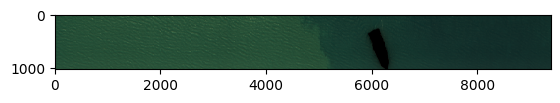

In [89]:
def enhance_brightness(non_glint_im,non_glint_mask_im,fp_name,dir,thresh=0.8):
    """
    non_glint_im (np.array): images with no glint
    non_glint_mask (np.array): binary mask of objects masked (where DN_obj=0, DN_water=1)
    fp_name (str): basename of image file (for saving afterwards)
    dir (str): filepath of directory of where to save the images
    thresh (float):  ranges from [0,1]. The threshold for identifying bright spots
    ---
    returns:
    1. a mask for glint (where DN_glint = 1, DN_nonglint = 0)
    2. simulated glint image *without* masked objects
    """
    mask = np.repeat(non_glint_mask_im[:,:,np.newaxis],3,axis=2)
    masked_img = non_glint_im*mask
    masked_img_cut = utils.cut_into_512(masked_img)
    mask_cut = utils.cut_into_512(mask)
    for im_c, mask_c in zip(masked_img_cut,mask_cut):
        inv_mask = np.where(mask>0,0,1)
        std_grey_im = utils.normalise_img(rgb2gray(im_c)) #already masked, greyscaled, then normalised
        glint_mask = std_grey_im > thresh #identify brightspots with DN > 0.8. brightspots will have DN = 1
        utils.save_img(glint_mask.astype(np.uint8),dir,fp_name,ext=".png")
        if np.sum(inv_mask) < 1: #if sum of mask is < 1 means it's all water body, dunnid to add back obj
            
            continue # go to the next loop
        else:

    return



enhance_brightness(non_glint[19],non_glint_mask[19],thresh=0.8)

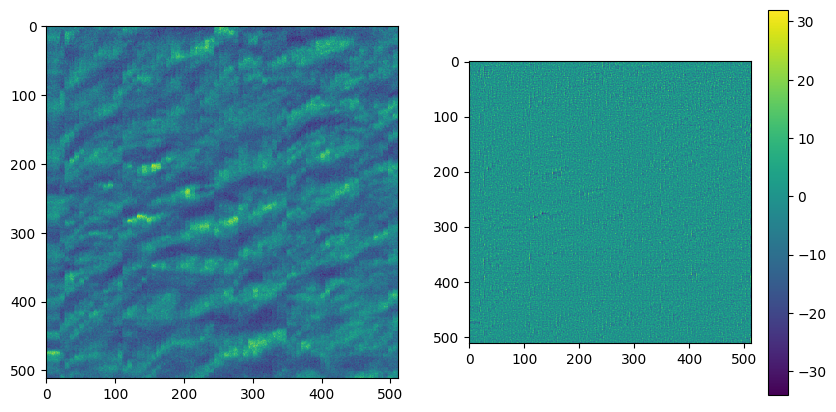

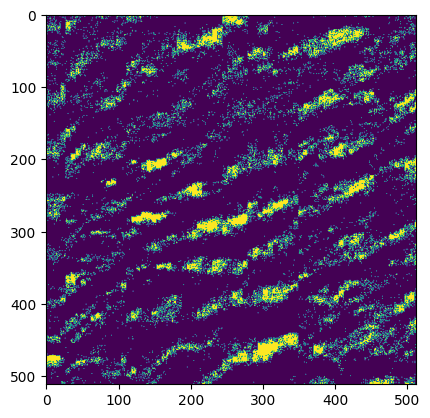

In [72]:
def identify_peaks(img):
    # denoise_img = cv.GaussianBlur(img,(3,3),0)
    # # apply laplace function
    # ddepth = cv.CV_16S
    # kernel_size = 3
    # laplacian_img = cv.Laplacian(denoise_img,ddepth,ksize=kernel_size)
    # fig,ax = plt.subplots(1,2,figsize=(10,5))
    # ax[0].imshow(img)
    # im = ax[1].imshow(laplacian_img)
    # plt.colorbar(im,ax=ax[1])
    # plt.colorbar()
    # standardisation of images
    im_min = np.min(img)
    im_max = np.max(img)
    im_std = (img - im_min)/(im_max-im_min)
    plt.figure()
    plt.imshow(im_std>0.5)

identify_peaks(clean_img_grey)